# Popularity of Music Records

The music industry has a well-developed market with a global annual revenue around $15 billion. The recording industry is highly competitive and is dominated by three big production companies which make up nearly 82% of the total annual album sales. 

Artists are at the core of the music industry and record labels provide them with the necessary resources to sell their music on a large scale. A record label incurs numerous costs (studio recording, marketing, distribution, and touring) in exchange for a percentage of the profits from album sales, singles and concert tickets.

Unfortunately, the success of an artist's release is highly uncertain: a single may be extremely popular, resulting in widespread radio play and digital downloads, while another single may turn out quite unpopular, and therefore unprofitable. 

Knowing the competitive nature of the recording industry, record labels face the fundamental decision problem of which musical releases to support to maximize their financial success. 

How can we use analytics to predict the popularity of a song? In this assignment, we challenge ourselves to predict whether a song will reach a spot in the Top 10 of the Billboard Hot 100 Chart.

Taking an analytics approach, we aim to use information about a song's properties to predict its popularity. The dataset `songs.csv` consists of all songs which made it to the Top 10 of the Billboard Hot 100 Chart from 1990-2010 plus a sample of additional songs that didn't make the Top 10. This data comes from three sources: Wikipedia, Billboard.com, and EchoNest.

The variables included in the dataset either describe the artist or the song, or they are associated with the following song attributes: `time signature`, `loudness`, `key`, `pitch`, `tempo`, and `timbre`.

Here's a detailed description of the variables:

__year__ = the year the song was released

__songtitle__ = the title of the song

__artistname__ = the name of the artist of the song

__songID__ and __artistID__ = identifying variables for the song and artist

__timesignature__ and __timesignature_confidence__ = a variable estimating the time signature of the song, and the confidence in the estimate

__loudness__ = a continuous variable indicating the average amplitude of the audio in decibels

__tempo__ and __tempo_confidence__ = a variable indicating the estimated beats per minute of the song, and the confidence in the estimate

__key__ and __key_confidence__ = a variable with twelve levels indicating the estimated key of the song (C, C#, . . ., B), and the confidence in the estimate

__energy__ = a variable that represents the overall acoustic energy of the song, using a mix of features such as loudness

__pitch__ = a continuous variable that indicates the pitch of the song

__timbre_0_min__, __timbre_0_max__, __timbre_1_min__, __timbre_1_max__, . . . , __timbre_11_min__, and __timbre_11_max__ = variables that indicate the minimum/maximum values over all segments for each of the twelve values in the timbre vector (resulting in 24 continuous variables)

__Top10__ = a binary variable indicating whether or not the song made it to the Top 10 of the Billboard Hot 100 Chart (1 if it was in the top 10, and 0 if it was not)

### Understanding the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
songs = pd.read_csv("../Data/songs.csv", encoding = "ISO-8859-1")
songs.head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,11,0.453,0.966656,0.024,0.002,57.342,-6.496,171.093,-81.664,95.117,-285.049,259.426,-40.385,73.630,-104.683,183.089,-88.771,73.549,-71.127,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.000,-4.051,140.048,0.921,10,0.469,0.984710,0.025,0.000,57.414,-37.351,171.130,-149.589,180.334,-380.143,384.166,-48.662,100.414,-87.267,42.798,-86.895,75.455,-65.807,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.000,-3.571,160.512,0.489,2,0.209,0.989900,0.026,0.003,57.422,-17.222,171.060,-72.912,157.925,-203.984,251.258,-66.044,152.095,-98.673,141.365,-88.874,66.504,-67.433,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.000,-3.815,97.525,0.794,1,0.632,0.939207,0.013,0.000,57.765,-32.083,220.895,-138.596,173.365,-73.490,373.492,-55.607,119.158,-77.515,141.178,-70.790,64.540,-63.667,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,2nd Sucks,A Day to Remember,SOICMQB1315CD46EE3,AROBSHL1187B9AFB01,4,0.788,-4.707,140.053,0.286,6,0.483,0.987738,0.063,0.000,56.872,-223.922,171.130,-147.153,166.008,-128.082,389.419,-43.908,99.332,-96.147,38.303,-110.757,72.391,-55.935,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0


In [3]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7574 entries, 0 to 7573
Data columns (total 39 columns):
year                        7574 non-null int64
songtitle                   7574 non-null object
artistname                  7574 non-null object
songID                      7574 non-null object
artistID                    7574 non-null object
timesignature               7574 non-null int64
timesignature_confidence    7574 non-null float64
loudness                    7574 non-null float64
tempo                       7574 non-null float64
tempo_confidence            7574 non-null float64
key                         7574 non-null int64
key_confidence              7574 non-null float64
energy                      7574 non-null float64
pitch                       7574 non-null float64
timbre_0_min                7574 non-null float64
timbre_0_max                7574 non-null float64
timbre_1_min                7574 non-null float64
timbre_1_max                7574 non-null float64
tim

In [4]:
songs.isnull().sum(axis=0)

year                        0
songtitle                   0
artistname                  0
songID                      0
artistID                    0
timesignature               0
timesignature_confidence    0
loudness                    0
tempo                       0
tempo_confidence            0
key                         0
key_confidence              0
energy                      0
pitch                       0
timbre_0_min                0
timbre_0_max                0
timbre_1_min                0
timbre_1_max                0
timbre_2_min                0
timbre_2_max                0
timbre_3_min                0
timbre_3_max                0
timbre_4_min                0
timbre_4_max                0
timbre_5_min                0
timbre_5_max                0
timbre_6_min                0
timbre_6_max                0
timbre_7_min                0
timbre_7_max                0
timbre_8_min                0
timbre_8_max                0
timbre_9_min                0
timbre_9_m

How many observations (songs) are from year 2010?

In [5]:
len(songs[songs["year"]==2010])

373

How many songs does the dataset include for which the artist name is "Michael Jackson"?

In [6]:
len(songs[songs["artistname"]=="Michael Jackson"])

18

Which of these songs by Michael Jackson made it to the Top 10?

In [7]:
songs[["year", "songtitle"]][(songs["artistname"]=="Michael Jackson")&(songs["Top10"]==1)]

,year,songtitle
4328,2001,You Rock My World
6206,1995,You Are Not Alone
6209,1995,Black or White
6217,1995,Remember the Time
6914,1992,In The Closet


The variable corresponding to the estimated time signature (timesignature) is discrete, meaning that it only takes integer values (0, 1, 2, 3, ...). What are the values of this variable that occur in our dataset?

In [8]:
songs["timesignature"].unique()

array([3, 4, 5, 7, 1, 0], dtype=int64)

Which timesignature value is the most frequent among songs in our dataset?

In [9]:
songs["timesignature"].value_counts()

4    6787
3     503
1     143
5     112
7      19
0      10
Name: timesignature, dtype: int64

Out of all the songs in our dataset, what is the song with the highest tempo?

In [10]:
songs[songs["tempo"]==songs["tempo"].max()][["year", "songtitle", "artistname"]]

,year,songtitle,artistname
6205,1995,Wanna Be Startin' Somethin',Michael Jackson


### Creating our Prediction Model

We wish to predict whether or not a song will make it to the Top 10. To do this, first use the subset function to split the data into a training set "SongsTrain" consisting of all observations up to and including 2009 song release, and a testing set "SongsTest", consisting of the 2010 song releases. How many observations (songs) are in the training set?

In [11]:
SongsTrain = songs[songs["year"]<=2009]
SongsTest = songs[songs["year"]==2010]

len(SongsTrain)

7201

In this problem, our outcome variable is "Top10" - we are trying to predict whether or not a song will make it to the Top 10 of the Billboard Hot 100 Chart. Since the outcome variable is binary, we will build a logistic regression model. We will start by using all songs attributes as our independent variables, which we will call Model 1.

We will only use the variables in our dataset that describe the numerical attributes of the song in our logistic regression model. So we whould not use the variables "year", "songtitle", "artistname", "songID" or "artistID".


In [12]:
features = ['timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10']

In [13]:
SongsTrain = SongsTrain[features]
SongsTest = SongsTest[features]

Now we build a logistic regression model to predict Top10 using all of the other variables as independent variables and "SongsTrain" dataset.

#### Logistic Regression
We consider the problem of predicting a binary response $Y$ using multiple $p$ predictors $X_{1}, X_{2}, ..., X_{p}$. Logistic regression models the probability that $Y$ belongs to a particular category.

\begin{equation}
p(X)=Pr(Y=1|X)
\end{equation}

For convinience we are using the generic $0/1$ coding for response. In logistic regression, we use the logistic function

\begin{equation}
p(X)=\frac{e^{\beta_{0}+\beta_{1}X_{1}+...+\beta_{p}X_{p}}}{1+e^{\beta_{0}+\beta_{1}X_{1}+...+\beta_{p}X_{p}}}
\end{equation}

We use the maximum likelihood method to estimate $\beta_{0},\beta_{1},...\beta_{p}$. See [[1]](#Reference) for more details.

In [14]:
from statsmodels.api import add_constant
from statsmodels.discrete.discrete_model import Logit, DiscreteResults

X_train = SongsTrain[['timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max']]

y_train = SongsTrain["Top10"]

X_train = add_constant(X_train) # for intersept in model

logit_mod = Logit(y_train, X_train)
logit_res = logit_mod.fit()

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.330451
         Iterations 8


C:\Users\Olena\Conda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Top10   No. Observations:                 7201
Model:                          Logit   Df Residuals:                     7167
Method:                           MLE   Df Model:                           33
Date:                Thu, 29 Aug 2019   Pseudo R-squ.:                  0.2091
Time:                        19:56:09   Log-Likelihood:                -2379.6
converged:                       True   LL-Null:                       -3008.8
Covariance Type:            nonrobust   LLR p-value:                2.683e-243
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       14.7000      1.806      8.138      0.000      11.160      18.240
timesignature                0.1264      0.087      1.457      0.145      -0.044       0.296
timesignature_confidence     0.7450      0.195      3.814      0.000       0.362       1.128
loudness                     0.2999      0.029     10.282      0.000       0.243       0.357
tempo                        0.0004      0.002      0.215      0.830      -0.003       0.004
tempo_confidence             0.4732      0.142      3.328      0.001       0.195       0.752
key                          0.0159      0.010      1.529      0.126      -0.004       0.036
key_confidence               0.3087      0.141      2.187      0.029       0.032       0.585
energy                      -1.5021      0.310     -4.847      0.000      -2.110      -0.895
pitch                      -44.9077      6.835     -6.570      0.000     -58.304     -31.511
timbre_0_min                 0.0232      0.004      5.441      0.000       0.015       0.032
timbre_0_max                -0.3310      0.026    -12.882      0.000      -0.381      -0.281
timbre_1_min                 0.0059      0.001      7.542      0.000       0.004       0.007
timbre_1_max                -0.0002      0.001     -0.342      0.732      -0.002       0.001
timbre_2_min                -0.0021      0.001     -1.889      0.059      -0.004    7.95e-05
timbre_2_max                 0.0007      0.001      0.726      0.468      -0.001       0.002
timbre_3_min                 0.0007      0.001      1.156      0.248      -0.000       0.002
timbre_3_max                -0.0030      0.001     -5.103      0.000      -0.004      -0.002
timbre_4_min                 0.0104      0.002      5.237      0.000       0.007       0.014
timbre_4_max                 0.0061      0.002      3.942      0.000       0.003       0.009
timbre_5_min                -0.0056      0.001     -4.385      0.000      -0.008      -0.003
timbre_5_max              7.736e-05      0.001      0.097      0.922      -0.001       0.002
timbre_6_min                -0.0169      0.002     -7.445      0.000      -0.021      -0.012
timbre_6_max                 0.0037      0.002      1.675      0.094      -0.001       0.008
timbre_7_min                -0.0045      0.002     -2.554      0.011      -0.008      -0.001
timbre_7_max                -0.0038      0.002     -2.060      0.039      -0.007      -0.000
timbre_8_min                 0.0039      0.003      1.372      0.170      -0.002       0.009
timbre_8_max                 0.0040      0.003      1.336      0.182      -0.002       0.010
timbre_9_min                 0.0014      0.003      0.456      0.648      -0.005       0.007
timbre_9_max                 0.0016      0.002      0.659      0.510      -0.003       0.006
timbre_10_min                0.0041      0.002      2.244      0.025       0.001       0.008
timbre_10_max                0.0058      0.002      3.292      0.001       0.00

What is the value of Akaike Information Criterion (AIC)?

In [15]:
DiscreteResults.aic(logit_res)

4827.154102388616

Let us now think about the variables in our datasets related to the confidence of the time signature, key and tempo (timesignature_confidence, key_confidence, and tempo_confidence). Our model seems to indicate that these confidence variables are significant (rather than the variables timesignature, key, and tempo). So the model suggests that the higher our confidence about time signature, key and tempo, the more likely the song is to be in the Top 10.

In general, if the confidence is low for time signature, tempo, and key, then the song is more likely to be complex. Our model suggests that mainstream listeners tend to preffer less complex songs.

Songs with heavier instrumentation tend to be louder (have higher values in the variable "loudness") and more energetic (have higher values in variable "energy"). By inspecting the coefficient of the variable "loudness", our model suggests that mainstream listeners prefer songs with heavy instrumentation.

### Beware of multicollinearity issues

What is the correlation between the variables "loudness" and "energy" in the training set?

In [16]:
SongsTrain[["loudness","energy"]].corr()

,loudness,energy
loudness,1.000000,0.739907
energy,0.739907,1.000000


Given taht these two variables are highly correlated, the model sudders from multicillinearity. to avoid this issue, we will ommit one of these two variables and rerun logistic regression.

Model 2 without variable "loudness".

In [17]:
X_train = SongsTrain[['timesignature', 'timesignature_confidence', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max']]

y_train = SongsTrain["Top10"]

X_train = add_constant(X_train) # for intersept in model

logit_mod2 = Logit(y_train, X_train)
logit_res2 = logit_mod2.fit()

logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.338276
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Top10   No. Observations:                 7201
Model:                          Logit   Df Residuals:                     7168
Method:                           MLE   Df Model:                           32
Date:                Thu, 29 Aug 2019   Pseudo R-squ.:                  0.1904
Time:                        19:56:10   Log-Likelihood:                -2435.9
converged:                       True   LL-Null:                       -3008.8
Covariance Type:            nonrobust   LLR p-value:                3.082e-220
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2406      0.746     -3.002      0.003      -3.704      -0.778
timesignature                0.1625      0.087      1.860      0.063      -0.009       0.334
timesignature_confidence     0.6885      0.192      3.578      0.000       0.311       1.066
tempo                        0.0006      0.002      0.332      0.740      -0.003       0.004
tempo_confidence             0.5497      0.141      3.906      0.000       0.274       0.825
key                          0.0174      0.010      1.697      0.090      -0.003       0.038
key_confidence               0.2954      0.139      2.118      0.034       0.022       0.569
energy                       0.1813      0.261      0.695      0.487      -0.330       0.692
pitch                      -51.4986      6.857     -7.511      0.000     -64.937     -38.060
timbre_0_min                 0.0248      0.004      5.847      0.000       0.016       0.033
timbre_0_max                -0.1007      0.012     -8.551      0.000      -0.124      -0.078
timbre_1_min                 0.0071      0.001      9.265      0.000       0.006       0.009
timbre_1_max                -0.0008      0.001     -1.108      0.268      -0.002       0.001
timbre_2_min                -0.0016      0.001     -1.424      0.155      -0.004       0.001
timbre_2_max                 0.0004      0.001      0.434      0.664      -0.001       0.002
timbre_3_min                 0.0007      0.001      1.093      0.275      -0.001       0.002
timbre_3_max                -0.0025      0.001     -4.339      0.000      -0.004      -0.001
timbre_4_min                 0.0091      0.002      4.670      0.000       0.005       0.013
timbre_4_max                 0.0063      0.002      4.115      0.000       0.003       0.009
timbre_5_min                -0.0056      0.001     -4.495      0.000      -0.008      -0.003
timbre_5_max                 0.0007      0.001      0.889      0.374      -0.001       0.002
timbre_6_min                -0.0161      0.002     -7.214      0.000      -0.021      -0.012
timbre_6_max                 0.0038      0.002      1.768      0.077      -0.000       0.008
timbre_7_min                -0.0051      0.002     -2.907      0.004      -0.009      -0.002
timbre_7_max                -0.0032      0.002     -1.744      0.081      -0.007       0.000
timbre_8_min                 0.0045      0.003      1.597      0.110      -0.001       0.010
timbre_8_max                 0.0064      0.003      2.177      0.029       0.001       0.012
timbre_9_min                -0.0004      0.003     -0.145      0.885      -0.006       0.005
timbre_9_max                 0.0035      0.002      1.483      0.138      -0.001       0.008
timbre_10_min                0.0030      0.002      1.660      0.097      -0.001       0.007
timbre_10_max                0.0074      0.002      4.255      0.000       0.004       0.011
timbre_11_min               -0.0284      0.004     -7.815      0.000      -0.03

In [18]:
from statsmodels.api import add_constant
from statsmodels.discrete.discrete_model import Logit, DiscreteResults

X_train = SongsTrain[['timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max']]

y_train = SongsTrain["Top10"]

X_train = add_constant(X_train) # for intersept in model

logit_mod3 = Logit(y_train, X_train)
logit_res3 = logit_mod3.fit()

logit_res3.summary()

Optimization terminated successfully.
         Current function value: 0.332087
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Top10   No. Observations:                 7201
Model:                          Logit   Df Residuals:                     7168
Method:                           MLE   Df Model:                           32
Date:                Thu, 29 Aug 2019   Pseudo R-squ.:                  0.2052
Time:                        19:56:10   Log-Likelihood:                -2391.4
converged:                       True   LL-Null:                       -3008.8
Covariance Type:            nonrobust   LLR p-value:                4.186e-239
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       11.9606      1.714      6.977      0.000       8.601      15.320
timesignature                0.1151      0.087      1.319      0.187      -0.056       0.286
timesignature_confidence     0.7143      0.195      3.670      0.000       0.333       1.096
loudness                     0.2306      0.025      9.120      0.000       0.181       0.280
tempo                       -0.0006      0.002     -0.388      0.698      -0.004       0.003
tempo_confidence             0.3841      0.140      2.747      0.006       0.110       0.658
key                          0.0165      0.010      1.593      0.111      -0.004       0.037
key_confidence               0.3394      0.141      2.409      0.016       0.063       0.616
pitch                      -53.2841      6.733     -7.914      0.000     -66.480     -40.088
timbre_0_min                 0.0220      0.004      5.200      0.000       0.014       0.030
timbre_0_max                -0.3105      0.025    -12.240      0.000      -0.360      -0.261
timbre_1_min                 0.0054      0.001      7.086      0.000       0.004       0.007
timbre_1_max                -0.0005      0.001     -0.719      0.472      -0.002       0.001
timbre_2_min                -0.0023      0.001     -2.012      0.044      -0.004   -5.86e-05
timbre_2_max                 0.0004      0.001      0.457      0.648      -0.001       0.002
timbre_3_min                 0.0003      0.001      0.542      0.588      -0.001       0.001
timbre_3_max                -0.0030      0.001     -5.147      0.000      -0.004      -0.002
timbre_4_min                 0.0110      0.002      5.585      0.000       0.007       0.015
timbre_4_max                 0.0065      0.002      4.196      0.000       0.003       0.009
timbre_5_min                -0.0051      0.001     -4.046      0.000      -0.008      -0.003
timbre_5_max                 0.0003      0.001      0.379      0.705      -0.001       0.002
timbre_6_min                -0.0178      0.002     -7.945      0.000      -0.022      -0.013
timbre_6_max                 0.0034      0.002      1.580      0.114      -0.001       0.008
timbre_7_min                -0.0051      0.002     -2.900      0.004      -0.009      -0.002
timbre_7_max                -0.0034      0.002     -1.865      0.062      -0.007       0.000
timbre_8_min                 0.0037      0.003      1.301      0.193      -0.002       0.009
timbre_8_max                 0.0047      0.003      1.559      0.119      -0.001       0.011
timbre_9_min             -9.318e-05      0.003     -0.032      0.975      -0.006       0.006
timbre_9_max                 0.0013      0.002      0.554      0.580      -0.003       0.006
timbre_10_min                0.0041      0.002      2.217      0.027       0.000       0.008
timbre_10_max                0.0058      0.002      3.294      0.001       0.002       0.009
timbre_11_min               -0.0264      0.004     -7.162      0.000      -0.03

We make predictions on the test set using Model 3.

In [19]:
X_test = SongsTest[['timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max']]

X_test = add_constant(X_test) # for intersept in model

y_test = SongsTest["Top10"]

Top10Pred = logit_res3.predict(X_test)

#### Confusion Matrix
A binary classifier can make two types of errors: positive cases that were incorrectly identified as negative and negative cases that were incorrectly identified as positive. Performance of such classifier is evaluated using the _confusion matrix_


$$\begin{matrix}
   Actual/Predicted\\
   \begin{matrix}
   & No & Yes\\
   No & a & b\\
   Yes & c & d
   \end{matrix} 
\end{matrix} $$

#### Accuracy

- $a, d$ are the numbers of _correct_ predictions of negative/positive examples
- $b, c$ are the numbers of _incorrect_ predictions of negative/positive examples
- The _accuracy_ is the proportion of the predictions that are correct
$$ \frac{a+d}{a+b+c+d} $$

#### True Positive Rate, False Positive Rate

- True positive rate is a proportion of positive cases that were correctly identify
$$ TP = \frac{d}{d+c}$$
- False positive rate is a proportion of negative cases that were incorrectly identify
$$ FP = \frac{b}{a+b}$$
- True negative rate is a proportion of negative cases that were correctly identify
$$ TN = \frac{a}{a+b}$$
- False negative rate is a proportion of positive cases that were incorrectly identify
$$ FN = \frac{c}{d+c}$$
- $Sensitivity = TP, Specificity = TN = 1-FP$

#### The ROC

- The ROC curve is a graphic for displaying the two types of errors for all possible _thresholds_
$$ Pr(Y="Yes"|X=x)>threshold$$
- _Threshold_ is the cutoff imposed on the predicted probabilities for assigning observation to each class

#### The ROC, AUC

The overall performance of a classifier is given by the area under the ROC curve (AUC). An ideal ROC curve will hug the top left corner, so the larger the AUC the better classifier.


Confussion matrix

In [20]:
pd.crosstab(y_test, Top10Pred >= 0.45, colnames=["Top10Pred"])

Top10Pred,False,True
Top10,,
0,309,5
1,40,19


What is the accuracy of the Model 3 on the test, using a threshold of 0.45?

In [21]:
(y_test==(Top10Pred >= 0.45)).mean()

0.8793565683646113

Let us check if there is any incremental benefit in using Model 3 instead of a baseline model (most frequent outcome). What whould the accuracy of the baseline model be on the test set?

In [22]:
(y_test.value_counts()/len(y_test))

0    0.841823
1    0.158177
Name: Top10, dtype: float64

It seems that Model 3 gives us a small improvment over baseline model. Still, does it create an edge?

Let us  view the two models from investment perspective. A production company is interested in i9nvesting in songs that are highly likely to make it to the Top 10. The company's objective is to minimize its risk of finansial losses attributed to investing in songs that end up unpopular.

A competetive edge can therefore be achieved if we can provide the production company a list of songs that are highly likely to end up in the Top 10. We note that the baseline model does not prove useful, as it simply does not label any songs as a hit. Let us see what our model has to offer.

How many songs does Model 3 correctly predict (remember that all songs in 2010 went into our test set), using a threshold of 0.45?

In [23]:
(y_test==(Top10Pred >= 0.45)).sum()

328

What is the sensitivity of Model 3 on the test set, using a threshold of 0.45?

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, Top10Pred, drop_intermediate=False)

In [25]:
#thresholds

In [26]:
#tpr

What is the spesificity of Model 3 on the test set, using a threshold of 0.45?

In [27]:
#1 - fpr

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc=roc_auc_score(y_test, Top10Pred)
roc_auc

0.85

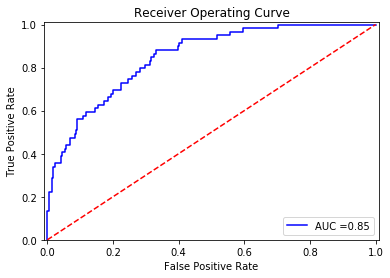

In [35]:
plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = f"AUC ={round(roc_auc,2)}" )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Reference

1. [Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, An Introduction to Statistical Learning with Applications in R, 2013.](http://faculty.marshall.usc.edu/gareth-james/ISL/)